In [1]:
%reload_ext autoreload
%autoreload 2
# allow iterative matplotlib plots
# %matplotlib widget
%matplotlib inline

In [2]:
from IPython import display
import sys, os
sys.path.append(os.path.join(os.getcwd(),'..','..'))

import numpy as np
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib import gridspec
import imageio.v3 as imageio
import glob
from tqdm import tqdm

from CBOSS.bayesian_models.classification import LaplaceGaussianProcessClassification
from CBOSS.bayesian_models.kernels import PolynomialKernel, CombKernel, DiscreteDiffusionKernel, HammingKernel, RBFKernel
from CBOSS.bayesian_models.svgp import *

## 1D example

In [3]:
''' Init true function and measurements
============================'''

# y_true_fun = lambda x: x**2 * np.sin(5 * np.pi * x)**6.0
# y_true_fun = lambda X:  ((0 < X) * (X < 0.5) + (1 < X) * (X < 1.3)).to(int)
y_true_fun = lambda X:  ((0 < X) * (X < 1.3)).to(int)

x_range_train = (-2,3)
x_range_pred = (-3,5)
N = 20
X = torch.rand(N, 1, dtype=torch.double) * (x_range_train[1]-x_range_train[0]) + x_range_train[0]
y = y_true_fun(X)[:,0]
X_pred = torch.linspace(*x_range_pred, 1000, dtype=torch.double)[:,None]


In [4]:
''' Initialize Model
============================'''        

gpc = LaplaceGaussianProcessClassification(
    X=X, y=y, 
    kernel = RBFKernel(length_scales=0.5, variance_prior=10),
).double()

gpc.train()
opt_state = gpc.fit(lr=0.1, maxiter=1, maxevals_per_iter=int(1e3), tolerance_change=0., tolerance_grad=1e-9)
gpc.eval()

gpc_y_pred = gpc.predictive_y_posterior(X_pred=X_pred)


Ns = 50
s = torch.rand(N).argsort()[:Ns]
svgpc = SVGP(
    X=X, y=y, s=s,
    kernel = RBFKernel(length_scales=1.0, variance_prior=10),
    likelihood = BernoulliSigmoidLikelihood(),
    batch_size = N,
    optimizer='lbfgs'
).double()

svgpc.train()
svgpc.fit(lr=1, maxiter=1000)
svgpc.eval()
# f_pred = svgpc.predictive_f_posterior(X_pred)
svgpc_y_pred = svgpc.predictive_y_posterior(X_pred)
# y_pred = f_pred



======== GPClass. train report ===========
	Time elapsed: 0.2 s
	nbr evals:      37
	residual_delta: 1.8e-07
	residual_g:     4.4e-15

	K.variance_prior               : [10.00] -> [10.00]
	K.length_scales                : [0.50] -> [0.50]
==== ENDOF GPClass. train report ===========


========  SVGP train report ============
	Time elapsed:   0.1 s
	nbr evals:      37
	elbo:           -7.8e+00
	
	K.variance_prior               : [10.00] -> [20.04]
	K.length_scales                : [1.00] -> [0.61]
======== EOF SVGP train report ==========



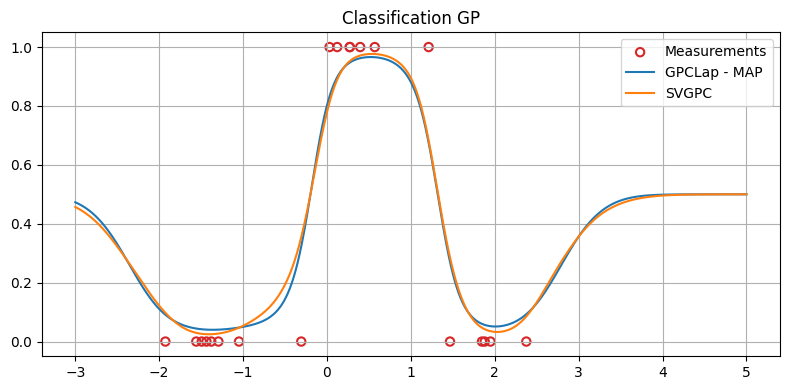

In [5]:


fig = plt.figure(figsize=(8,4))
plt.scatter( X.squeeze().numpy(), y.numpy(), c='tab:red', s=6**2, marker=MarkerStyle('o', 'none'), label='Measurements')
# plt.plot( X_pred.squeeze(), prob_true_label__MC.detach().numpy(), label='GPCLap - MC' )
plt.plot( X_pred.squeeze(), gpc_y_pred.mean.detach().numpy(), label='GPCLap - MAP' )
plt.plot( X_pred.squeeze(), svgpc_y_pred.mean.detach().numpy(), label='SVGPC' )
plt.grid()
plt.legend()
plt.title('Classification GP')
plt.tight_layout()
plt.show()

## Banana dataset

In [6]:
N = 500

dataset = pd.read_csv( Path(os.getcwd()) / 'banana.csv')

dataset['At1'] = (dataset['At1'] - dataset['At1'].mean()) / dataset['At1'].std()
dataset['At2'] = (dataset['At2'] - dataset['At2'].mean()) / dataset['At2'].std()

idx = np.random.permutation(len(dataset))[:N]

X = torch.tensor(dataset.iloc[idx, :-1].values).double()
y = torch.tensor(dataset.iloc[idx, -1].values).double()
y = torch.where(y==-1, 0., y)

X_pred = torch.stack(torch.meshgrid(torch.linspace(-3,3,30), torch.linspace(-3,3,30), indexing='ij'), dim=-1).reshape(-1,2).double()

In [7]:
# yl = y.clone().int()
# yl[yl==-1] = 0
gpc = LaplaceGaussianProcessClassification(
    X=X, y=y, 
    kernel = RBFKernel(length_scales=.2, variance_prior=30.),
).double()

gpc.fit(lr=0.1, maxiter=1, maxevals_per_iter=int(1e3), tolerance_change=1e-9, tolerance_grad=1e-9)
gpc.eval()

gpc_y_pred = gpc.predictive_y_posterior(X_pred=X_pred)



======== GPClass. train report ===========
	Time elapsed: 0.8 s
	nbr evals:      83
	residual_delta: 2.0e-05
	residual_g:     2.2e-11

	K.variance_prior               : [30.00] -> [30.00]
	K.length_scales                : [0.20] -> [0.20]
==== ENDOF GPClass. train report ===========



In [8]:
Ns = 20
s = torch.rand(N).argsort()[:Ns]

svgpc = SVGP(
    X=X, y=y, s=s,
    kernel = RBFKernel(length_scales=1.0, variance_prior=30.),
    likelihood = BernoulliSigmoidLikelihood(),
    batch_size = N,
    optimizer='lbfgs'
).double()

svgpc.fit(lr=1.0, maxiter=1000)
svgpc.eval()
# f_pred = svgpc.predictive_f_posterior(X_pred)
svgpc_y_pred = svgpc.predictive_y_posterior(X_pred)
# y_pred = f_pred


========  SVGP train report ============
	Time elapsed:   3.3 s
	nbr evals:      150
	elbo:           -1.9e+02
	
	K.variance_prior               : [30.00] -> [170.73]
	K.length_scales                : [1.00] -> [1.50]
======== EOF SVGP train report ==========



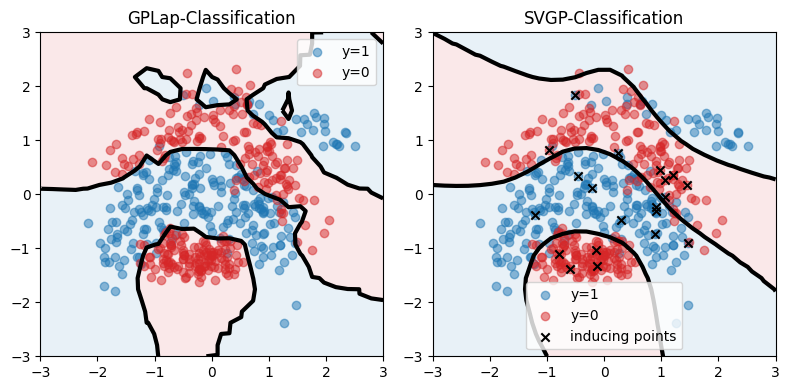

In [9]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

axs[0].contourf(X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), gpc_y_pred.mean.reshape(30,30), levels=[0,0.5], colors='#fae8e9')#, colors='tab:red', alpha=0.1)
axs[0].contourf(X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), gpc_y_pred.mean.reshape(30,30), levels=[0.5,1], colors='#e8f1f7')#, colors='tab:blue', alpha=0.1)
axs[0].scatter(X[y==1,0], X[y==1,1], c='tab:blue', marker='o', label='y=1', alpha=0.5)
axs[0].scatter(X[y==0,0], X[y==0,1], c='tab:red', marker='o', label='y=0', alpha=0.5)
axs[0].contour( X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), gpc_y_pred.mean.reshape(30,30), levels=[0.5], colors='k', linewidths=3)
axs[0].legend()
axs[0].set_title('GPLap-Classification')

axs[1].contourf(X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), svgpc_y_pred.mean.reshape(30,30), levels=[0,0.5], colors='#fae8e9')#colors='tab:red', alpha=0.1)
axs[1].contourf(X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), svgpc_y_pred.mean.reshape(30,30), levels=[0.5,1], colors='#e8f1f7')#colors='tab:blue', alpha=0.1)
axs[1].scatter(X[y==1,0], X[y==1,1], c='tab:blue', marker='o', label='y=1', alpha=0.5)
axs[1].scatter(X[y==0,0], X[y==0,1], c='tab:red', marker='o', label='y=0', alpha=0.5)
axs[1].contour( X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), svgpc_y_pred.mean.reshape(30,30), levels=[0.5],   colors='k', linewidths=3)
axs[1].scatter(X[s,0], X[s,1], c='k', marker='x', label='inducing points')
axs[1].legend()
axs[1].set_title('SVGP-Classification')

plt.tight_layout()

## Create Animation

In [10]:
%%script false --no-raise-error

from tqdm import tqdm

Ns = 500
s = torch.arange(Ns)

for i in tqdm(range(0,500,5)):
    
    Xi = X[:i+1]
    yi = y[:i+1]
    si = s[:i+1]

    svgpc = SVGP(
        X=Xi, y=yi, s=si,
        kernel = RBFKernel(length_scales=1.28, variance_prior=90.),
        likelihood = BernoulliSigmoidLikelihood(),
        batch_size = N,
        optimizer='lbfgs'
    ).double()
    
    svgpc.K.length_scales.raw.requires_grad = False
    svgpc.K.variance_prior.raw.requires_grad = False

    svgpc.fit(lr=1.0, maxiter=1000, disp=False)
    svgpc.eval()
    # f_pred = svgpc.predictive_f_posterior(X_pred)
    svgpc_y_pred = svgpc.predictive_y_posterior(X_pred)
    # y_pred = f_pred
    
    
    fig, axs = plt.subplots(1,1, figsize=(4,4))

    axs.contourf(X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), svgpc_y_pred.mean.reshape(30,30), levels=[0,0.5], colors='#fae8e9') #, colors='tab:red', alpha=0.1)
    axs.contourf(X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), svgpc_y_pred.mean.reshape(30,30), levels=[0.5,1], colors='#e8f1f7') #, colors='tab:blue', alpha=0.1)
    axs.scatter(Xi[yi==1,0], Xi[yi==1,1], c='tab:blue', marker='o', label='y=1', alpha=0.5)
    axs.scatter(Xi[yi==0,0], Xi[yi==0,1], c='tab:red', marker='o', label='y=0', alpha=0.5)
    axs.contour( X_pred[:,0].reshape(30,30), X_pred[:,1].reshape(30,30), svgpc_y_pred.mean.reshape(30,30), levels=[0.5],   colors='k', linewidths=3)
    # axs.scatter(Xi[si,0], Xi[si,1], c='k', marker='x', label='inducing points')
    axs.legend()
    axs.set_title('SVGP-Classification')

    plt.tight_layout()
    plt.savefig(f'./classification_animation/banana_2D_{i:03d}.png')
    plt.close()

In [11]:
%%script false --no-raise-error

from PIL import Image

total_time = 10.

images = []
filenames = glob.glob('./classification_animation/*.png')
filenames.sort()
for filename in tqdm(filenames):
    # images.append(imageio.imread(filename))
    im = Image.open(filename)
    alpha = im.split()[3]
    im = im.convert('RGB').convert('P', palette=Image.ADAPTIVE, colors=255)
    mask = Image.eval(alpha, lambda a: 255 if a <=128 else 0)
    im.paste(255, mask)
    images.append(im)
    
# imageio.imwrite(
#     './classification_animation/classification_SVGP.gif', images, 
#     duration=total_time/len(filenames), loop=0, palettesize=256, subrectangles=False, optimize=False
# )
images[0].save(
    './classification_animation/classification_SVGP.gif',
    save_all=True,
    append_images=images[1:],
    duration=total_time/len(filenames),
    loop=0,
    optimize=False,
    quality=100,
    subrectangles=False,
    # transparency=1,
)
